In [9]:
import os
import yaml
import numpy as np

!pwd

def print_result(algo, target, mode):
    if mode == 'continual': 
        file = 'global.yaml'
        index=-1
        print_ci95 = False
    else:
        file = f'global-{mode}.yaml'
        index='all'
        print_ci95 = True
    exp_path = f'/mnt/d/Documents/Github/CODA-Prompt-experiments/CGQA/10-task/{algo}/results-{target}/{file}'
    with open(exp_path, 'r') as yaml_file:
        yaml_result = yaml.safe_load(yaml_file)
    
    if index == 'all':
        data = np.asarray(yaml_result['mean'])      # [300]
    else:
        data = np.asarray(yaml_result['mean'][index])      # [-1]
    avg = np.mean(data)
    if print_ci95:
        std = np.std(data)
        ci95 = 1.96 * (std/np.sqrt(len(data)))
        print(f'{avg:.2f}% +- {ci95:.2f}%')
    else:
        ci95 = 0
        print(f'{avg:.2f}%')
    return avg, ci95

algo = 'coda-p-r-0'         # coda-p dual-prompt l2p++ coda-p-r
target = 'acc'
for mode in ['continual', 'sys', 'pro', 'sub', 'non', 'noc']:      # 
    print(f'{mode}:')
    print_result(algo, target, mode)



/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/mnt/d/Documents/Github/CODA-Prompt
continual:
55.36%
sys:
71.72% +- 0.76%
pro:
71.37% +- 0.69%
sub:
81.45% +- 0.61%
non:
74.55% +- 0.69%
noc:
84.07% +- 0.59%


# Visualize mo

In [1]:

import types
import yaml
import copy

import numpy as np
import torch
from torch.utils.data import DataLoader

from trainer import Trainer
from learners.pmo_utils import cal_hv_loss
from learners.pmo_utils import draw_objs


args = types.SimpleNamespace()
args.config = 'configs/cgqa_prompt.yaml' 
args.gpuid = [0]
args.repeat = 1 
args.overwrite = 1 
args.learner_type = 'pmo'    # prompt
args.learner_name = 'PMOPrompt' 
args.prompt_param = [100, 8, 0.0, 2]        # [4] -> n_obj
args.memory = 0 
args.log_dir = '../CODA-Prompt-experiments/CGQA/10-task/pmo-10-4-1'     # pmo-10-4-0   coda-p
args.debug_mode = 1
args.dataroot = '../../../OneDrive - City University of Hong Kong - Student/datasets'
args.oracle_flag = False
args.upper_bound_flag = False
args.temp = 2
args.DW = False
args.mode = 'continual'
args.test_model = -1

config = yaml.load(open(args.config, 'r'), Loader=yaml.Loader)
config.update(vars(args))

args = types.SimpleNamespace(**config)
args.batch_size = 10

metric_keys = ['acc','time',]
save_keys = ['global', 'pt', 'pt-local']
global_only = ['time']
avg_metrics = {}
for mkey in metric_keys: 
    avg_metrics[mkey] = {}
    for skey in save_keys: avg_metrics[mkey][skey] = []

def prepare(trainer=None, task_id=-1): 
    if trainer is None: 
        trainer = Trainer(args, 0, metric_keys, save_keys)      # new trainer
    
    if task_id > -1: 
        i = task_id
        trainer.current_t_index = i
        train_name = trainer.task_names[i]
        print('======================', train_name, '=======================')
        
        task = trainer.tasks_logits[i]
        trainer.train_dataset.load_dataset(i, train=True)
        trainer.add_dim = len(task)
        
        if i > 0: 
            trainer.learner.model.prompt.process_task_count()
        
        # load model
        model_save_dir = trainer.model_top_dir + '/models/repeat-'+str(trainer.seed+1)+'/task-'+trainer.task_names[i]+'/'
        trainer.learner.task_count = i 
        trainer.learner.add_valid_output_dim(len(trainer.tasks_logits[i]))
        trainer.learner.pre_steps()
    
        trainer.learner.load_model(model_save_dir)  # load last model
        trainer.learner.model.task_id = i    
        
        trainer.learner.data_weighting(trainer.train_dataset)   

    return trainer


*****************************************
====================== 1 =======================
Incremental class: Old valid output dimension: 0
Incremental class: New Valid output dimension: 10
=> Load Done
aq_k in layer0: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
aq_k in layer1: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
aq_k in layer2: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
aq_k in layer3: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
aq_k in layer4: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
aq_k in layer0: tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], device='cuda:0')
aq_k in layer1: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
aq_k in layer2: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
aq_k in layer3: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
aq_k in layer4: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,

/mnt/d/Documents/Github/CODA-Prompt/learners/pmo_utils.py:683: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


aq_k in layer0: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0')
aq_k in layer1: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
aq_k in layer2: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0')
aq_k in layer3: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

FileNotFoundError: [Errno 2] No such file or directory: '../CODA-Prompt-experiments/CGQA/10-task/pmo-10-4-1/models/repeat-1/task-9/class.pth'

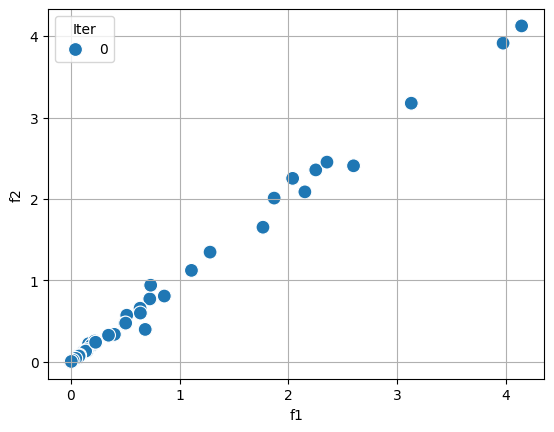

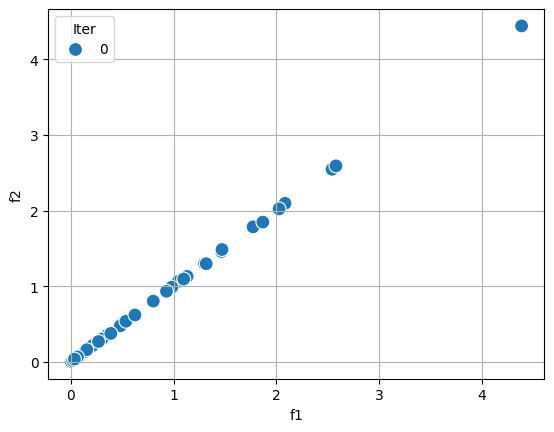

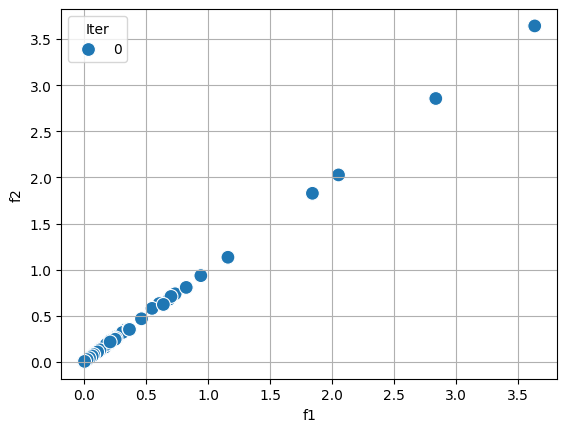

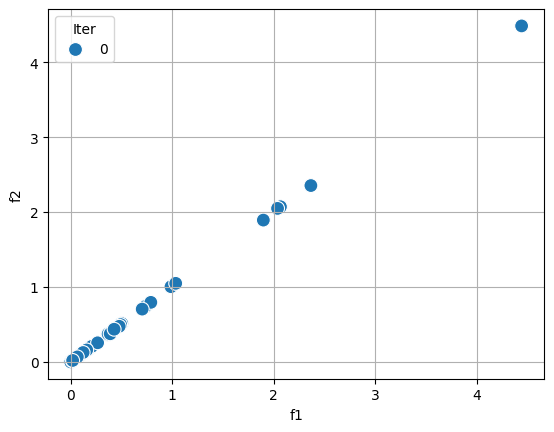

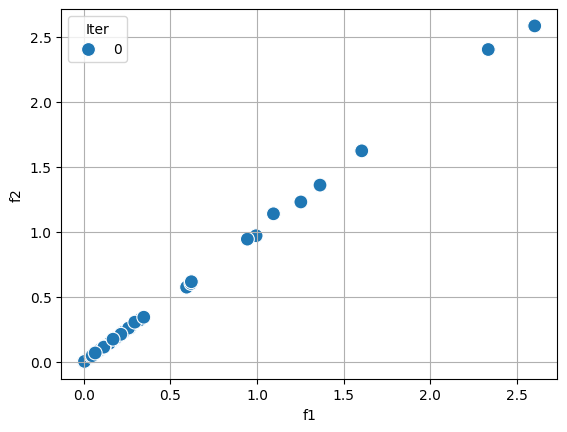

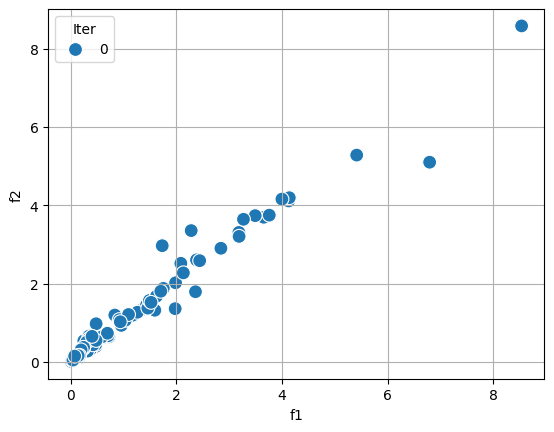

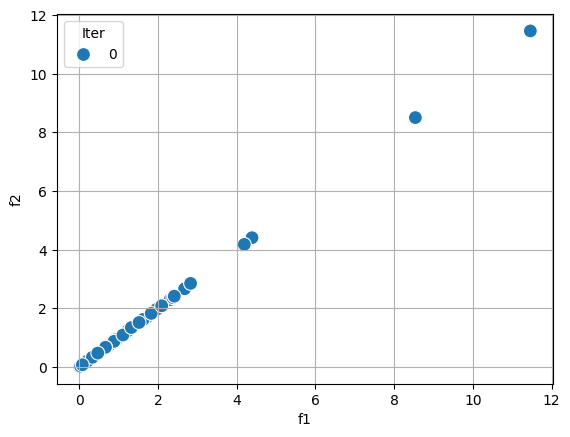

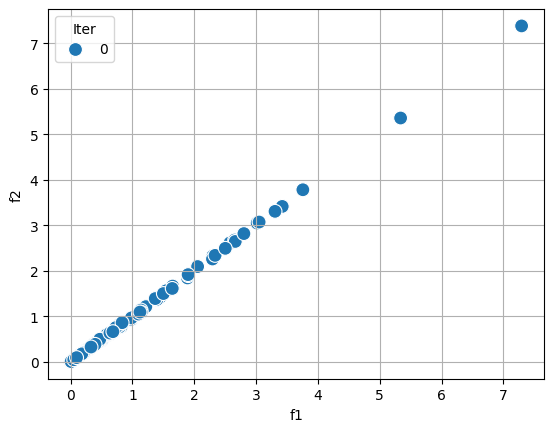

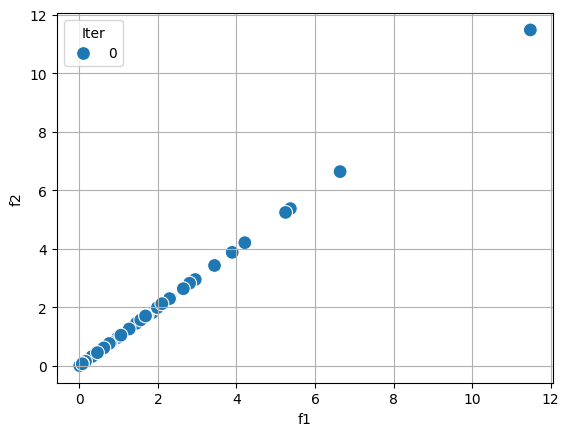

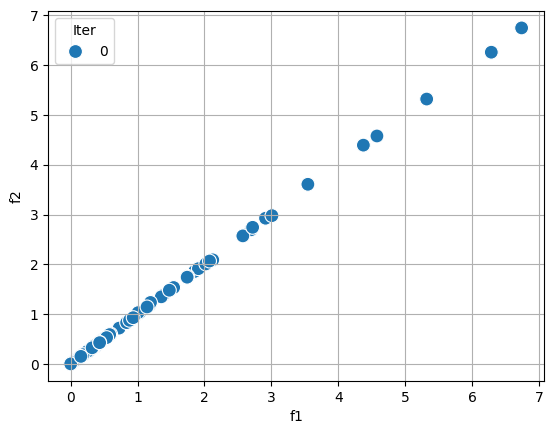

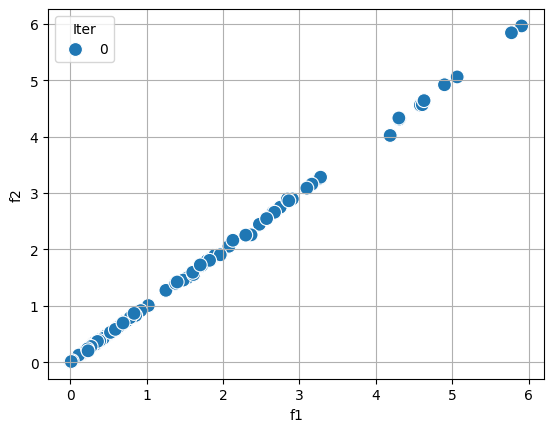

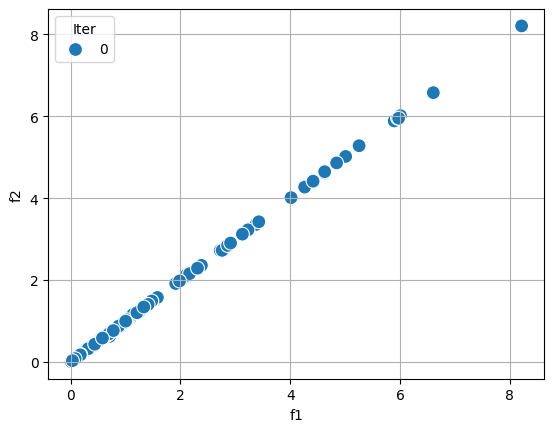

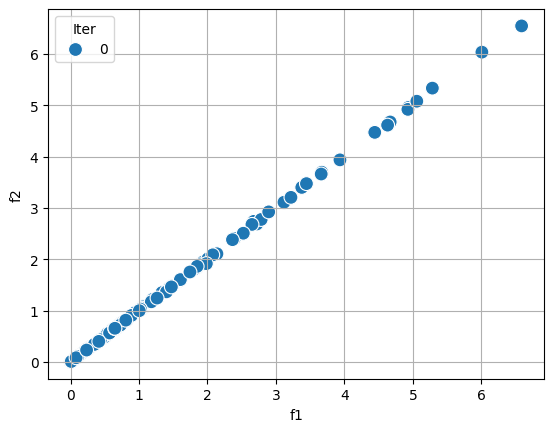

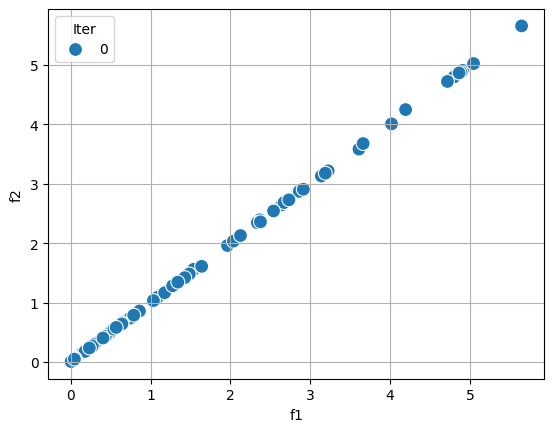

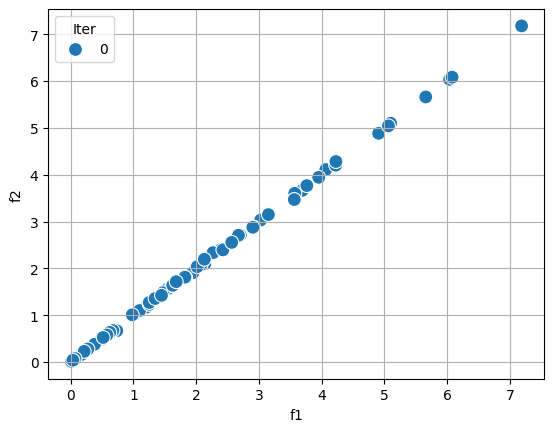

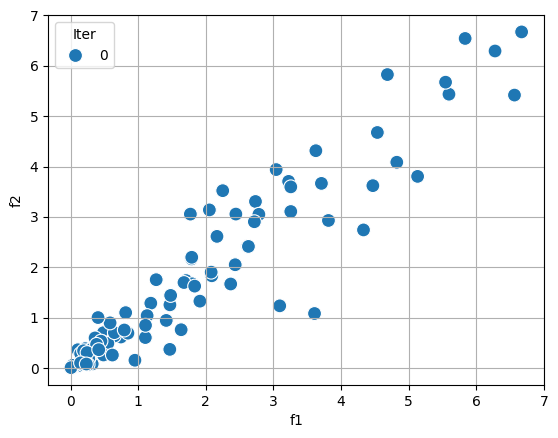

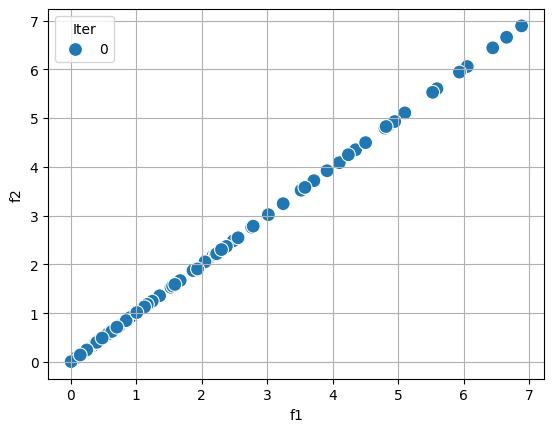

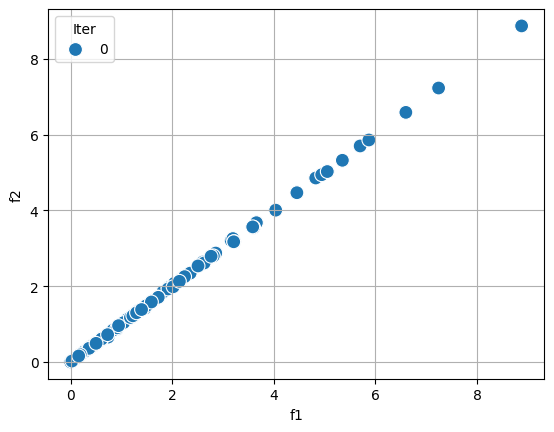

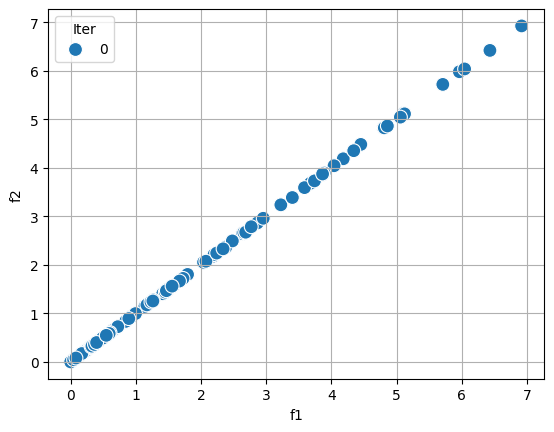

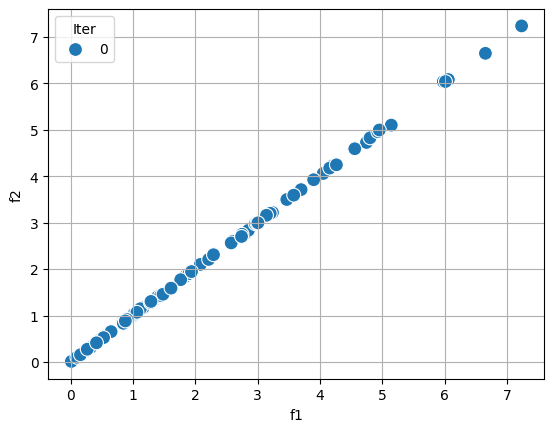

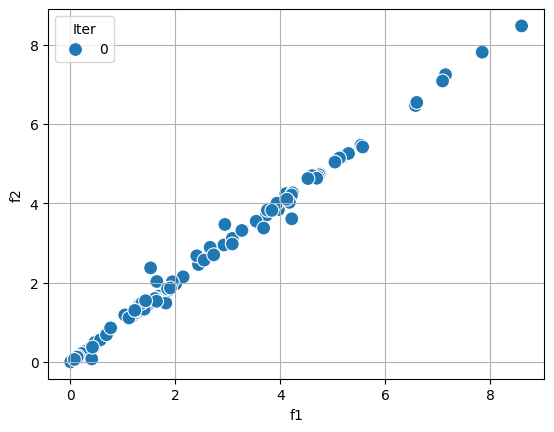

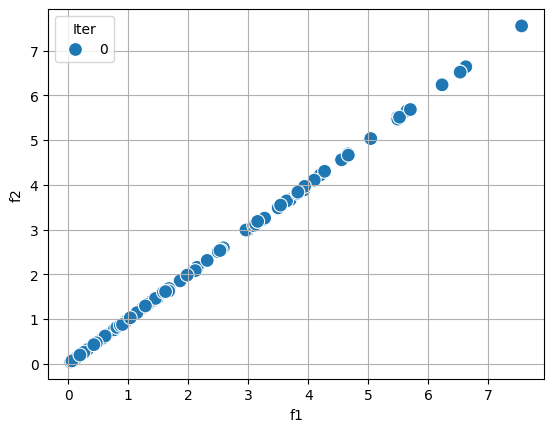

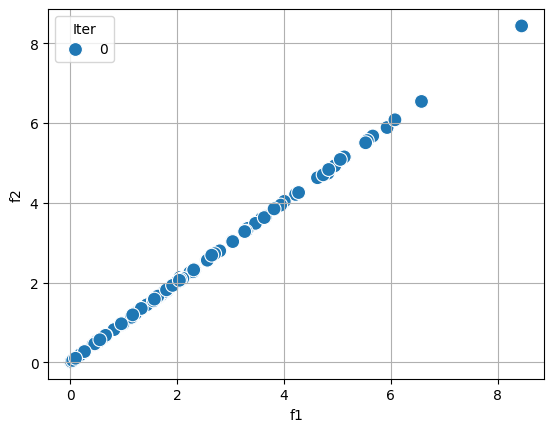

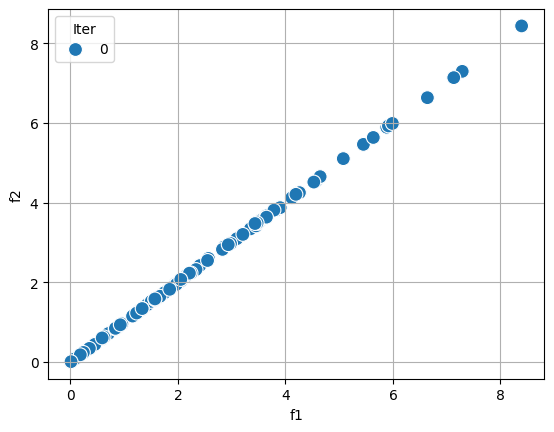

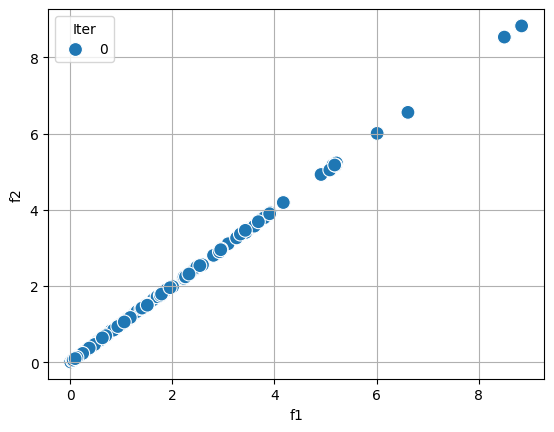

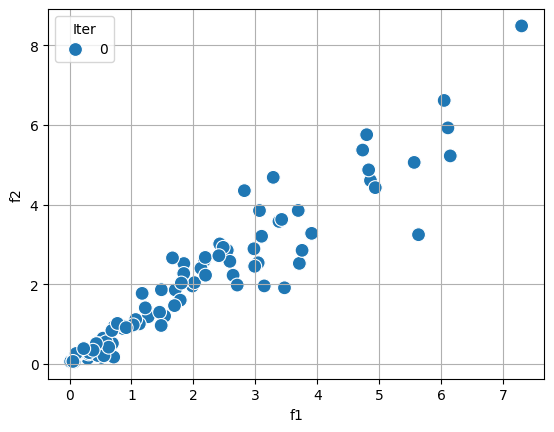

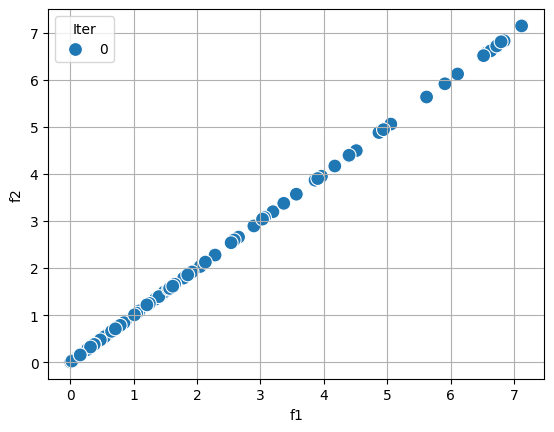

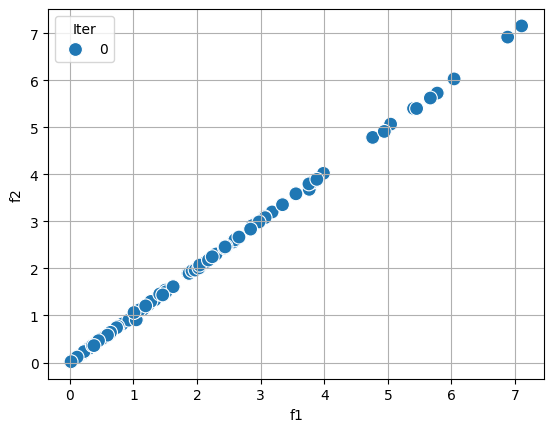

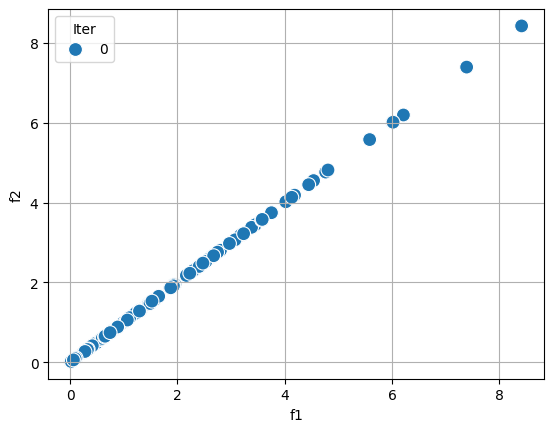

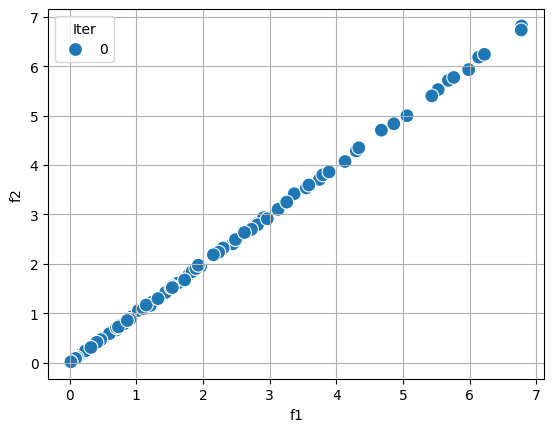

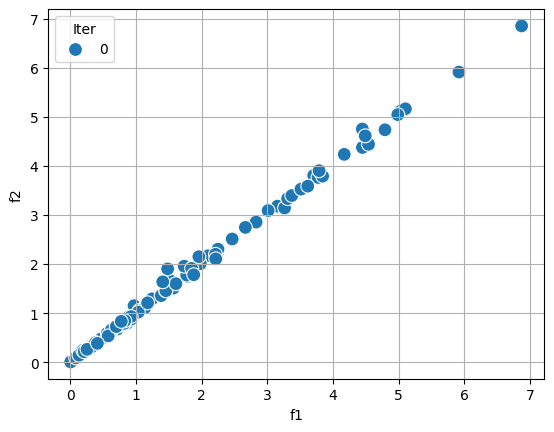

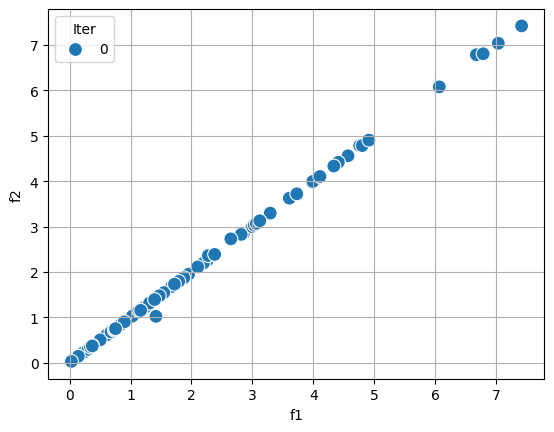

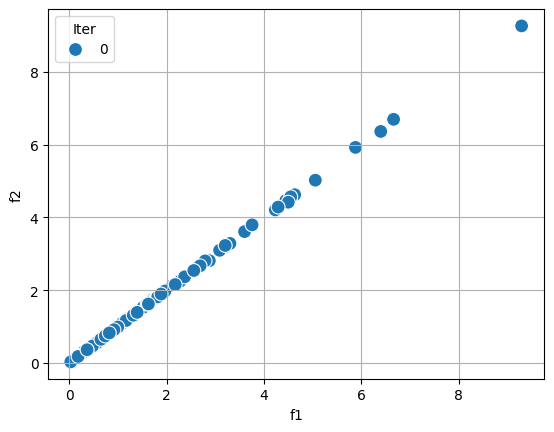

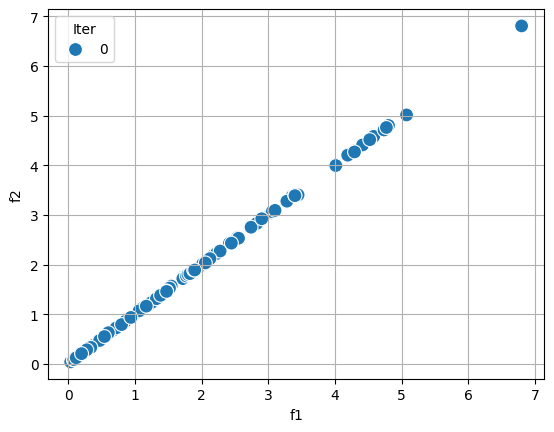

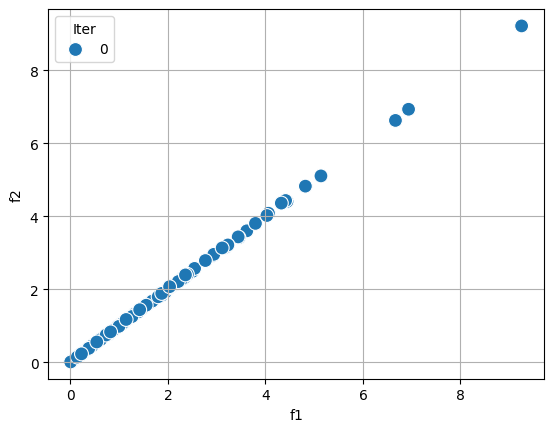

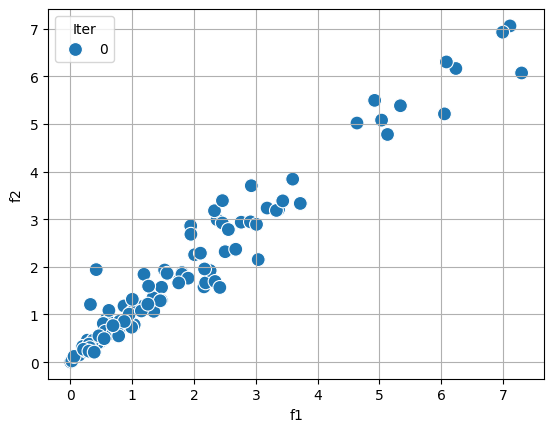

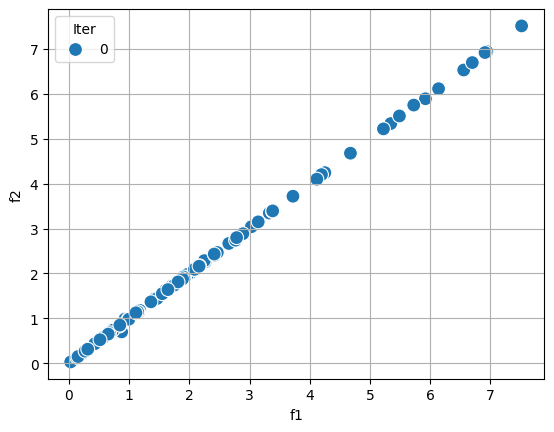

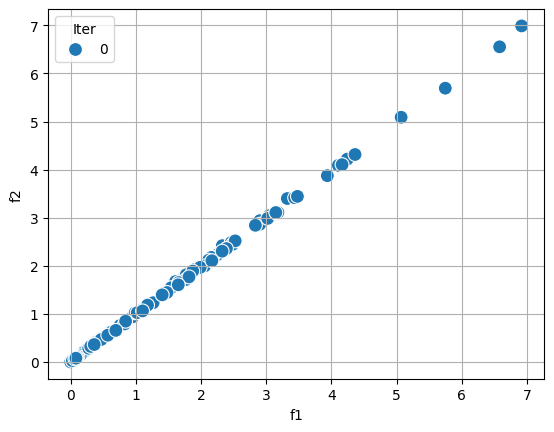

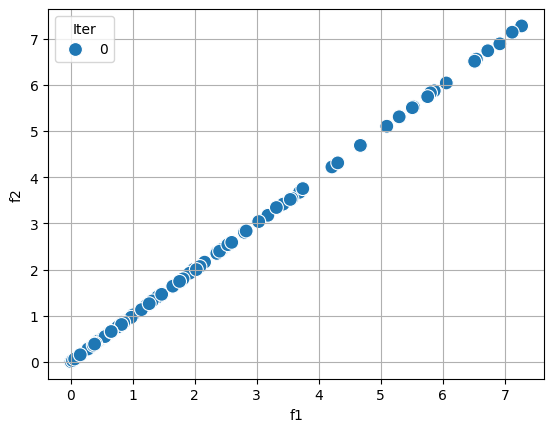

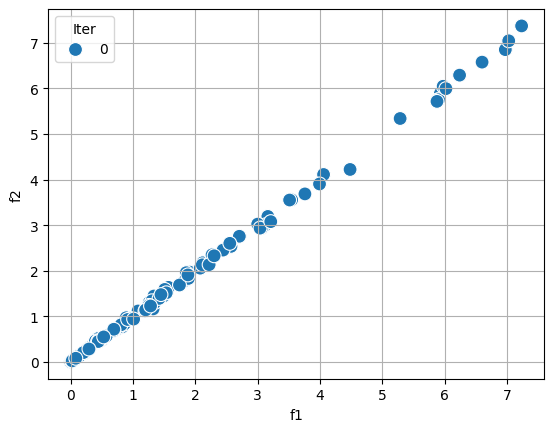

In [2]:
trainer = None
for i in range(10): 
# i=0
    trainer = prepare(trainer, task_id=i)
    
    learner = trainer.learner
    model = learner.model
    prompt = model.prompt
    learner.aux.update_source(trainer.train_dataset)
    
    learner.epoch = 0
    
    for layer_idx in [0, 1,2,3, 4]:
        mo_matrix = learner.obtain_mo_matrix(hard_l=layer_idx, add_noise=False)
        # print(f'mo_matrix: {mo_matrix}')
        hv_loss = cal_hv_loss(mo_matrix, ref=None)
        print(hv_loss)
        figure = draw_objs(mo_matrix.detach().cpu().numpy()[np.newaxis, :2, :], None)   # only f1-f2
        figure.savefig(f'{args.log_dir}/temp/mo_task{i}_l{layer_idx}_f1-f2.png', bbox_inches='tight')